<a href="https://colab.research.google.com/github/sreesriavvaru123/MI/blob/main/MI_detection_v3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab-compatible notebook for MI detection using PTB-XL with 12-leads and 10-fold CV



## STEP 1: Install necessary packages



In [1]:
!pip install wfdb scikit-learn matplotlib tensorflow --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 58.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


## STEP 2: Import required libraries


In [2]:
import numpy as np
import pandas as pd
import wfdb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.signal import butter, filtfilt

## STEP 3: Download and unzip PTB-XL data

In [3]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"avvarusrinivasulu","key":"fe47c5051ef67f1130ff6e2e1fa439be"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle CLI if not already
!pip install -q kaggle

# Download the PTB-XL dataset
!kaggle datasets download -d khyeh0719/ptb-xl-dataset

# Unzip the dataset
!unzip ptb-xl-dataset.zip -d ptb-xl


Streaming output truncated to the last 5000 lines.
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/1934

## STEP 4: Load metadata and diagnostic class mapping

In [5]:
def apply_diagnostic_filter(data, class_map):
    data['diagnostic_class'] = data.scp_codes.apply(
        lambda x: list(set([class_map.loc[k].diagnostic_class for k in eval(x) if k in class_map.index])))
    data['is_MI'] = data.diagnostic_class.apply(lambda x: 1 if 'MI' in x else 0)
    return data

ptbxl_path = "/content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"
print("Loading metadata...")
df = pd.read_csv(ptbxl_path + 'ptbxl_database.csv')
df['filename_lr'] = ptbxl_path + df['filename_lr']  # 500Hz files in filename_hr based on user

class_map = pd.read_csv(ptbxl_path + 'scp_statements.csv', index_col=0)
df = apply_diagnostic_filter(df, class_map)
df_binary = df[['filename_lr', 'is_MI']]

Loading metadata...


In [10]:
print("MI cases:", (df['is_MI'] == 1).sum())
print("Non-MI cases:", (df['is_MI'] == 0).sum())
print("Total records:", len(df))

# Load the class map
class_map = pd.read_csv(ptbxl_path + 'scp_statements.csv', index_col=0)

# Filter only diagnostic classes
diagnostic_classes = class_map[class_map['diagnostic_class'].notnull()]['diagnostic_class'].unique()

# Display
print("Diagnostic classes in PTB-XL:")
for dc in sorted(diagnostic_classes):
    print("-", dc)

df['diagnostic_class'] = df['scp_codes'].apply(
    lambda x: list(set([class_map.loc[k].diagnostic_class for k in eval(x) if k in class_map.index])))

from collections import Counter
flat_list = [item for sublist in df['diagnostic_class'] for item in sublist]
diagnostic_counts = Counter(flat_list)

# Show all
for cls, count in diagnostic_counts.items():
    print(f"{cls}: {count}")

MI cases: 5486
Non-MI cases: 16351
Total records: 21837
Diagnostic classes in PTB-XL:
- CD
- HYP
- MI
- NORM
- STTC
nan: 21230
NORM: 9528
MI: 5486
STTC: 5250
HYP: 2655
CD: 4907


## STEP 5: Load and preprocess ECG signals using bandpass filter

In [12]:
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=100, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    padlen = 3 * max(len(a), len(b))
    if signal.shape[1] <= padlen:
        signal = np.pad(signal, ((0, 0), (0, padlen - signal.shape[1] + 1)), mode='edge')
    return filtfilt(b, a, signal, axis=1)

def load_and_preprocess(filename):
    signal, _ = wfdb.rdsamp(filename)
    signal = signal[:1024, :].T  # 10s x 100Hz = 1000 samples, shape (12, 1024)

    # Apply bandpass filter (0.5–40 Hz)
    signal = bandpass_filter(signal)
    return signal

print("Loading and preprocessing ECGs...")
from tqdm import tqdm
X = []
missing_files = []

print("Loading and preprocessing ECGs...")
for f in tqdm(df_binary['filename_lr']):
    try:
        signal = load_and_preprocess(f)
        X.append(signal)
    except FileNotFoundError:
        missing_files.append(f)
        continue

X = np.array(X)
y = df_binary['is_MI'].astype(int).values

# Reshape for CNN input: (samples, leads, time, 1)
X = np.expand_dims(X, -1)

Loading and preprocessing ECGs...
Loading and preprocessing ECGs...


100%|██████████| 21837/21837 [01:23<00:00, 260.63it/s]


In [13]:
print("Labels in y:", np.unique(y))

Labels in y: [0 1]


In [14]:
print(np.shape(X))

(21837, 12, 1000, 1)


## STEP 6: Train-validation split

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


## STEP 7: Define Residual CNN model

In [17]:
def residual_block(x, filters):
    shortcut = layers.Conv2D(filters, (1, 1), padding='same')(x)
    x = layers.Conv2D(filters, (3, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

input_layer = layers.Input(shape=(12, 1000, 1))
x = layers.Conv2D(64, (3, 1), padding='same')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

for _ in range(4):
    x = residual_block(x, 64)
    x = layers.MaxPooling2D(pool_size=(1, 4))(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=input_layer, outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 12, 1000,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 12, 1000,  │        256 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 1000,  │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 12, 1000,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 12, 1000,  │     12,352 │ re_lu_9[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 1000,  │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 12, 1000,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 12, 1000,  │     12,352 │ re_lu_10[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 1000,  │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 12, 1000,  │      4,160 │ re_lu_9[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 12, 1000,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 12, 1000,  │          0 │ add_4[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 12, 250,   │          0 │ re_lu_11[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 12, 250,   │     12,352 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 250,   │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 12, 250,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 12, 250,   │     12,352 │ re_lu_12[0][0]  

 Total params: 118,081 (461.25 KB)

 Trainable params: 116,929 (456.75 KB)

 Non-trainable params: 1,152 (4.50 KB)

## STEP 8: Train the model strictly as per paper (no EarlyStopping)

In [18]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(patience=7, factor=0.1)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=40,
                    batch_size=32,
                    callbacks=[lr_reduce])

Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 63s 99ms/step - accuracy: 0.7965 - auc_1: 0.8137 - loss: 0.4447 - val_accuracy: 0.7483 - val_auc_1: 0.8788 - val_loss: 0.5685 - learning_rate: 0.0010
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 60s 72ms/step - accuracy: 0.8639 - auc_1: 0.9137 - loss: 0.3130 - val_accuracy: 0.8596 - val_auc_1: 0.9223 - val_loss: 0.3459 - learning_rate: 0.0010
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - accuracy: 0.8709 - auc_1: 0.9239 - loss: 0.2910 - val_accuracy: 0.8675 - val_auc_1: 0.9282 - val_loss: 0.3107 - learning_rate: 0.0010
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8775 - auc_1: 0.9299 - loss: 0.2825 - val_accuracy: 0.8777 - val_auc_1: 0.9308 - val_loss: 0.2824 - learning_rate: 0.0010
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.8840 - auc_1: 0.9361 - loss: 0.2709 - val_accuracy: 0.8527 - val_auc_1: 0.9276 - val_loss: 0.3428 - learning_rate: 0.0010
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/s

## Testing the Model

205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      4906
           1       0.77      0.73      0.75      1646

    accuracy                           0.88      6552
   macro avg       0.84      0.83      0.84      6552
weighted avg       0.88      0.88      0.88      6552

AUC Score: 0.9309853929450832


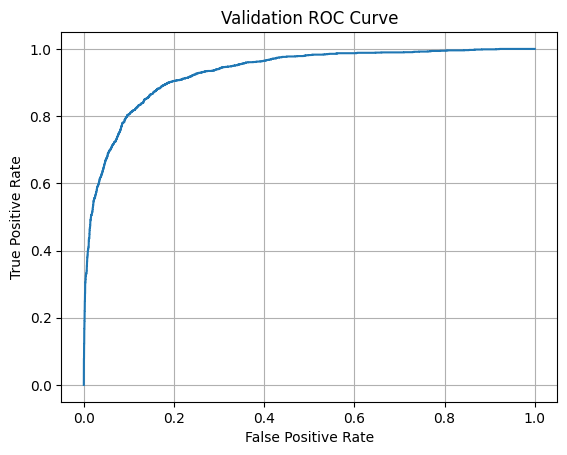

In [19]:
# Evaluate on test set
val_preds = model.predict(X_val)
val_preds_binary = (val_preds > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_val, val_preds_binary))
print("AUC Score:", roc_auc_score(y_val, val_preds))

# Plot ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_val, val_preds)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.grid(True)
plt.show()


# Save final model
model.save("mi_detection_resnet_model_v1.1.h5")

In [ ]:
print("Train class distribution:", np.bincount(y_train))
print("Val class distribution:", np.bincount(y_val))


Train class distribution: [15285]
Val class distribution: [6552]


## Tetsing on PTB database

In [20]:
# STEP 1: Install dependencies
!pip install wfdb scikit-learn numpy matplotlib

import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib  # or from tensorflow.keras.models import load_model if deep learning


In [21]:

# STEP 2: Download PTB Database (use PhysioNet mirror)
# !wget -r -N -c -np https://physionet.org/static/published-projects/ptbdb/ptb-diagnostic-ecg-database-1.0.0/ -P ptb_data
# STEP 2: Download via WFDB API
wfdb.dl_database('ptbdb', dl_dir='ptb_data')



Generating record list for: patient001/s0010_re
Generating record list for: patient001/s0014lre
Generating record list for: patient001/s0016lre
Generating record list for: patient002/s0015lre
Generating record list for: patient003/s0017lre
Generating record list for: patient004/s0020are
Generating record list for: patient004/s0020bre
Generating record list for: patient005/s0021are
Generating record list for: patient005/s0021bre
Generating record list for: patient005/s0025lre
Generating record list for: patient005/s0031lre
Generating record list for: patient005/s0101lre
Generating record list for: patient006/s0022lre
Generating record list for: patient006/s0027lre
Generating record list for: patient006/s0064lre
Generating record list for: patient007/s0026lre
Generating record list for: patient007/s0029lre
Generating record list for: patient007/s0038lre
Generating record list for: patient007/s0078lre
Generating record list for: patient008/s0028lre
Generating record list for: patient008/s

In [22]:
import zipfile
import os

# Example: Path to your zip file
zip_path = "/content/ptb_data.zip"
extract_to = "/content/ptb_data"

# Create destination directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Unzipped to: {extract_to}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/ptb_data.zip'

In [24]:
# import os

# for root, dirs, files in os.walk("ptb_data"):
#     for name in files:
#         if name.endswith(".hea"):
#             print(os.path.join(root, name))

# STEP 3: Collect 12-lead .hea files
import glob
import wfdb

record_paths = sorted(glob.glob("ptb_data/patient*/**/*.hea", recursive=True))
print("Found", len(record_paths), "records")

Found 549 records


In [25]:
# STEP 4: Define helpers for reading, resampling, segmenting


def read_12lead_ecg(path):
    rec = wfdb.rdrecord(path[:-4])
    # picks 12 standard leads, ignoring Frank leads
    data = rec.p_signal[:, :12].T  # (12, n_samples)
    return data, rec

def resample_to_100Hz(arr, orig=1000, target=100):
    num = int(arr.shape[1] * target / orig)
    return resample(arr, num, axis=1)




In [26]:
# STEP 5: Build test dataset
X_test, y_test = [], []

for p in record_paths:
    data, rec = read_12lead_ecg(p)
    r100 = resample_to_100Hz(data)
    seg = r100[:, :1000]  # 10 sec @ 100 Hz
    seg = bandpass_filter(seg)
    # Label extraction
    c = " ".join(rec.comments).lower()
    if "myocardial infarction" in c:
        y = 1
    elif "healthy" in c:
        y = 0
    else:
        continue
    X_test.append(seg); y_test.append(y)

X_test = np.array(X_test)  # (n,12,1000)
y_test = np.array(y_test)
print("Test data shape:", X_test.shape, "| Labels:", y_test.shape)



Test data shape: (448, 12, 1000) | Labels: (448,)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Shape of y_pred_prob: (448, 1)
Classification Report:

              precision    recall  f1-score   support

      Normal       0.18      1.00      0.30        80
          MI       0.00      0.00      0.00       368

    accuracy                           0.18       448
   macro avg       0.09      0.50      0.15       448
weighted avg       0.03      0.18      0.05       448



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


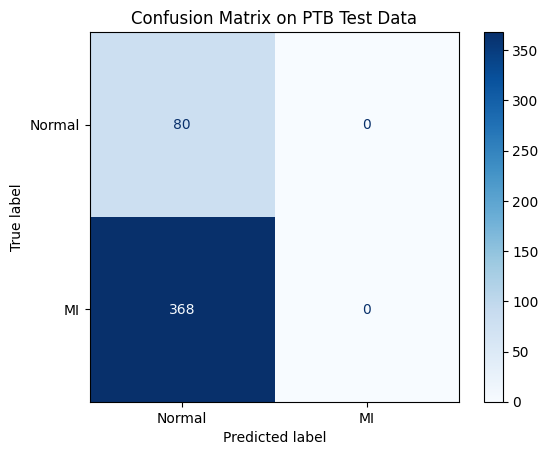

In [28]:
# STEP 6: Reshape if needed and load your trained model
# Example for sklearn or Keras model
# Reshape if your model needs (samples, features)

from tensorflow.keras.models import load_model

# Load model — adjust path as needed
# model = joblib.load("your_mi_model.pkl")  # Replace with your model path
model = load_model("mi_detection_resnet_model_v1.1.h5") # For Keras:

# STEP 7: Predict and evaluate
# Convert shape (N, 12, 1000) → (N, 1000, 12)
X_keras = np.transpose(X_test, (0, 1, 2))  # Time-first format

# Predict
y_pred_prob = model.predict(X_keras)

# If binary classification:
y_pred = np.argmax(y_pred_prob, axis=1)
print("Shape of y_pred_prob:", y_pred_prob.shape)
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Normal", "MI"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "MI"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on PTB Test Data")
plt.show()



In [ ]:
# !zip -r /content/ptb_data.zip /content/ptb_data

## STEP 8: 5-Fold Cross-Validation

In [ ]:
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# fold = 1
# histories, reports = [], []

# for train_index, test_index in skf.split(X, y):
#     print(f"\n--- Fold {fold} ---")
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#     model = build_resnet_model(X.shape[1:])
#     model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
#     early_stop = EarlyStopping(patience=5, restore_best_weights=True)

#     history = model.fit(X_train, y_train, epochs=30, batch_size=32,
#                         validation_split=0.2, callbacks=[early_stop], verbose=0)
#     histories.append(history)

#     y_pred = (model.predict(X_test) > 0.5).astype(int)
#     print(classification_report(y_test, y_pred))
#     cm = confusion_matrix(y_test, y_pred)
#     ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-MI', 'MI']).plot()
#     plt.title(f"Fold {fold} Confusion Matrix")
#     plt.show()
#     reports.append(classification_report(y_test, y_pred, output_dict=True))

#     # Save model from one fold for future testing
#     if fold == 1:
#         model.save('/content/mi_detector_resnet_fold1.h5')

#     fold += 1